# EGO with a failure region

In [1]:
from __future__ import annotations

import numpy as np
import tensorflow as tf

np.random.seed(1234)
tf.random.set_seed(1234)

## The problem

This notebook is similar to the [EI notebook](expected_improvement.ipynb), where we look to find the minimum value of the two-dimensional Branin function over the hypercube $[0, 1]^2$. But here, we constrain the problem, by adding an area to the search space in which the objective fails to evaluate.

We represent this setup with a function `masked_branin` that produces null values when evaluated in the disk with center $(0.5, 0.4)$ and radius $0.3$. It's important to remember that while _we_ know where this _failure region_ is, this function is a black box from the optimizer's point of view: the optimizer must learn it.

In [2]:
import trieste


def masked_branin(x):
    mask_nan = np.sqrt((x[:, 0] - 0.5) ** 2 + (x[:, 1] - 0.4) ** 2) < 0.3
    y = np.array(trieste.objectives.branin(x))
    y[mask_nan] = np.nan
    return tf.convert_to_tensor(y.reshape(-1, 1), x.dtype)

As mentioned, we'll search over the hypercube $[0, 1]^2$ ...

In [3]:
from trieste.space import Box

search_space = Box([0, 0], [1, 1])

... where the `masked_branin` now looks as follows. The white area in the centre shows the failure
region.

In [4]:
from util.plotting_plotly import plot_function_plotly

fig = plot_function_plotly(
    masked_branin, search_space.lower, search_space.upper, grid_density=70
)
fig.update_layout(height=400, width=400)
fig.show()

## Define the data sets

We'll work with two data sets

  - one containing only those query_points and observations where the observations are finite.
    We'll label this with `OBJECTIVE`.
  - the other containing all the query points, but whose observations indicate if evaluating the
    observer failed at that point, using `0` if the evaluation failed, else `1`. We'll label this
    with `FAILURE`.

Let's define an observer that outputs the data in these formats.

In [5]:
OBJECTIVE = "OBJECTIVE"
FAILURE = "FAILURE"


def observer(x):
    y = masked_branin(x)
    mask = np.isfinite(y).reshape(-1)
    return {
        OBJECTIVE: trieste.data.Dataset(x[mask], y[mask]),
        FAILURE: trieste.data.Dataset(x, tf.cast(np.isfinite(y), tf.float64)),
    }

We can evaluate the observer at points sampled from the search space.

In [6]:
num_init_points = 15
initial_data = observer(search_space.sample(num_init_points))

## Build GPflow models

We'll model the data on the objective with a regression model, and the data on which points failed with a classification model. The regression model will be a `GaussianProcessRegression` wrapping a GPflow `GPR` model, and the classification model a `VariationalGaussianProcess` wrapping a GPflow `VGP` model with Bernoulli likelihood.

In [7]:
import gpflow


def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=[0.2, 0.2])
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        variance=100.0, lengthscales=[0.2, 0.2]
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    gpflow.set_trainable(vgp.kernel.variance, False)
    return vgp


regression_model = create_regression_model(initial_data[OBJECTIVE])
classification_model = create_classification_model(initial_data[FAILURE])

## Build Trieste models

We now specify how Trieste will use our GPflow models within the BO loop.

For our `VGP` model we will use a non-default optimization: alternate Adam steps (to optimize kernel parameter) and NatGrad steps (to optimize variational parameters). For this we need to use the `BatchOptimizer` wrapper and set the `use_natgrads` model argument to `True` in our `VariationalGaussianProcess` model wrapper.

We'll train the GPR model with the default Scipy-based L-BFGS optimizer, and the VGP model with the custom algorithm above.

In [8]:
from trieste.models.gpflow.models import (
    GaussianProcessRegression,
    VariationalGaussianProcess,
)
from trieste.models.optimizer import BatchOptimizer

models: dict[str, trieste.models.ModelSpec] = {
    OBJECTIVE: GaussianProcessRegression(regression_model),
    FAILURE: VariationalGaussianProcess(
        classification_model,
        BatchOptimizer(tf.optimizers.Adam(1e-3)),
        use_natgrads=True,
    ),
}

## Create a custom acquisition function

We'll need a custom acquisition function for this problem. This function is the product of the expected improvement for the objective data and the predictive mean for the failure data. We can specify which data and model to use in each acquisition function builder with the `OBJECTIVE` and `FAILURE` labels. We'll optimize the function using EfficientGlobalOptimization.

In [9]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import (
    SingleModelAcquisitionBuilder,
    ExpectedImprovement,
    Product,
)


class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset=None):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean

        return acquisition


ei = ExpectedImprovement()
pov = ProbabilityOfValidity()
acq_fn = Product(ei.using(OBJECTIVE), pov.using(FAILURE))
rule = EfficientGlobalOptimization(acq_fn)  # type: ignore

## Run the optimizer

Now, we run the Bayesian optimization loop for twenty steps, and print the location of the query point corresponding to the minimum observation.

In [10]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

num_steps = 20
result = bo.optimize(
    num_steps, initial_data, models, rule
).final_result.unwrap()

arg_min_idx = tf.squeeze(
    tf.argmin(result.datasets[OBJECTIVE].observations, axis=0)
)
print(f"query point: {result.datasets[OBJECTIVE].query_points[arg_min_idx, :]}")

Optimization completed without errors


query point: [0.12295049 0.82040449]


We can visualise where the optimizer queried on a contour plot of the Branin with the failure region. The minimum observation can be seen along the bottom axis towards the right, outside of the failure region.

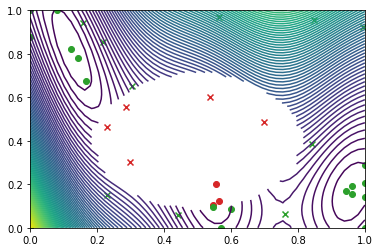

In [11]:
import matplotlib.pyplot as plt
from util.plotting import plot_gp_2d, plot_function_2d, plot_bo_points

mask_fail = (
    result.datasets[FAILURE].observations.numpy().flatten().astype(int) == 0
)
fig, ax = plot_function_2d(
    masked_branin,
    search_space.lower,
    search_space.upper,
    grid_density=50,
    contour=True,
)
plot_bo_points(
    result.datasets[FAILURE].query_points.numpy(),
    ax=ax[0, 0],
    num_init=num_init_points,
    mask_fail=mask_fail,
)
plt.show()

We can also plot the mean and variance of the predictive distribution over the search space, first for the objective data and model ...

In [12]:
from util.plotting_plotly import plot_gp_plotly, add_bo_points_plotly

arg_min_idx = tf.squeeze(
    tf.argmin(result.datasets[OBJECTIVE].observations, axis=0)
)

fig = plot_gp_plotly(
    result.models[OBJECTIVE].model,  # type: ignore
    search_space.lower,
    search_space.upper,
    grid_density=50,
)
fig = add_bo_points_plotly(
    x=result.datasets[OBJECTIVE].query_points[:, 0].numpy(),
    y=result.datasets[OBJECTIVE].query_points[:, 1].numpy(),
    z=result.datasets[OBJECTIVE].observations.numpy().flatten(),
    num_init=num_init_points,
    idx_best=arg_min_idx,
    fig=fig,
    figrow=1,
    figcol=1,
)

fig.show()

... and then for the failure data and model

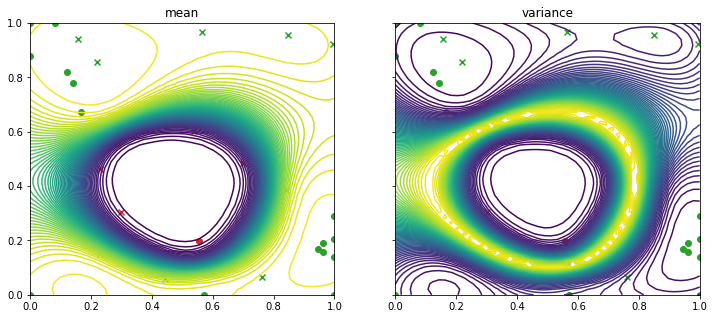

In [13]:
fig, ax = plot_gp_2d(
    result.models[FAILURE].model,  # type: ignore
    search_space.lower,
    search_space.upper,
    grid_density=50,
    contour=True,
    figsize=(12, 5),
    predict_y=True,
)

plot_bo_points(
    result.datasets[FAILURE].query_points.numpy(),
    num_init=num_init_points,
    ax=ax[0, 0],
    mask_fail=mask_fail,
)

plot_bo_points(
    result.datasets[FAILURE].query_points.numpy(),
    num_init=num_init_points,
    ax=ax[0, 1],
    mask_fail=mask_fail,
)

plt.show()

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)